# **Semi-Supervised Learning With GANs**
## Investigating the model performance with unlabelled CIFAR-10 datas

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, MaxPool2D, BatchNormalization
from keras.layers import LeakyReLU, Dropout, Lambda, Activation, ReLU, Softmax
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy, Accuracy

from keras import backend as K
from keras.optimizers import Adam
from keras.datasets import cifar10, mnist

from sklearn.model_selection import train_test_split
import seaborn as sns

from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T

from torchsummary import summary
from torch.utils.data import DataLoader,TensorDataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
torch.cuda.is_available()

False

In [4]:
# print(tf.config.list_physical_devices('GPU'))

# gpu_device = tf.config.list_physical_devices('GPU')[0]
# # tf.config.experimental.set_memory_growth(gpu_device, True)


# with tf.device('/GPU:0'):
#     # Create your TensorFlow model here
#     model = tf.keras.Sequential()


## Investigate the model accuraccy with 120 datas


### Dataset preparation


In [5]:
def get_images():
  (x_train, y_train), (x_test,y_test) = cifar10.load_data()
  # print(x_train.shape)
  # print(y_train.shape)
  # print(x_test.shape)
  # print(y_test.shape)

  # X = np.expand_dims(x_train, axis=-1).astype('float32')
  X = x_train/255.
  print(X.shape, y_train.shape)

  return [X, y_train]

dataset = get_images()
classes = ['airplane', 'automobile', 'bird',	'cat', 'deer',	'dog',	'frog',	'horse',	'ship',	'truck']

(50000, 32, 32, 3) (50000, 1)


In [6]:
image = dataset[0][12,:,:]

<function matplotlib.pyplot.show(close=None, block=None)>

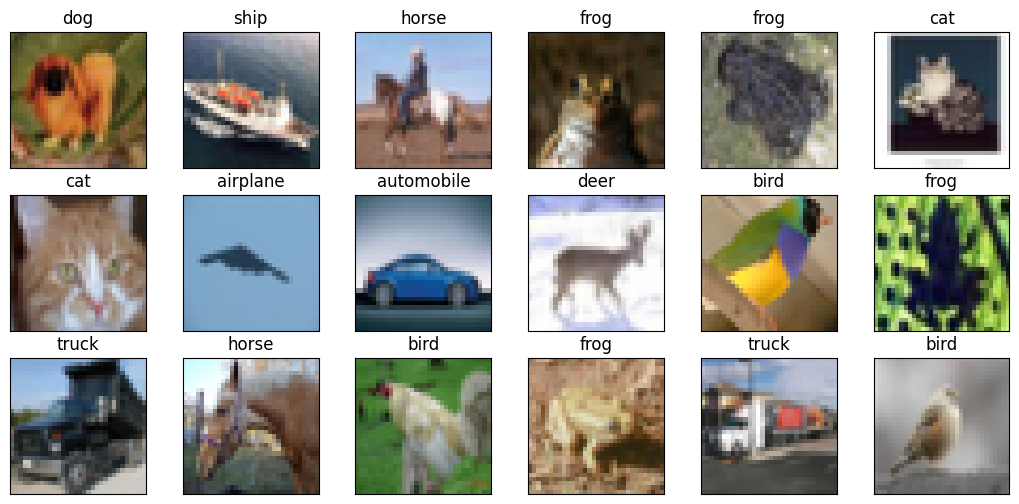

In [7]:
fig, axs = plt.subplots(3,6,figsize=(13,6))

for idx, ax in enumerate(axs.flatten()):
  randpic = np.random.randint(dataset[0].shape[0])
  image = dataset[0][randpic,:,:]
  # image = np.squeeze(image)

  label_idx = dataset[1][randpic][0]

  ax.set_title(classes[label_idx])
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(image, cmap='gray')

plt.show

In [8]:
labels = np.where(dataset[1] == 0)
print(labels[0])

[   29    30    35 ... 49941 49992 49994]


In [9]:
num_images = 120

def select_subset_images(dataset, n_samples = num_images, n_classes = 10):
  X, y = dataset
  X_list, y_list = list(), list()
  n_per_class = int(n_samples/n_classes) # 10 elements for each classes

  for i in range(n_classes):
    idx = np.where(y == i)[0]
    X_with_class= X[idx] # Get all images from this class
    ix = np.random.randint(0, len(X_with_class), n_per_class)
    [X_list.append(X_with_class[j]) for j in ix] # Add samples to the list
    [y_list.append(i) for j in ix]

  print(len(X_list))
  print(len(y_list))

  return np.asarray(X_list), np.asarray(y_list)

print(np.unique(dataset[1]))
X, Y = select_subset_images(dataset=dataset)

[0 1 2 3 4 5 6 7 8 9]
120
120


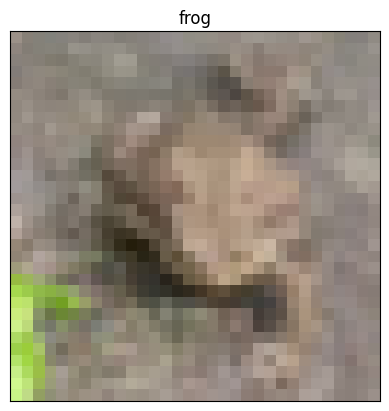

In [10]:
i = np.random.randint(X.shape[0])
randimg = np.squeeze(X[i])
plt.title(classes[Y[i]])
plt.xticks([])
plt.yticks([])
plt.imshow(randimg)

### Model preparation


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 0.2, random_state = 42)

model = Sequential()
model.add(Conv2D(32, (3,3), (2,2), activation = 'relu', input_shape = (32,32,3))) #for cifar10
# model.add(Conv2D(32, (3,3), (2,2), activation = 'relu', input_shape = (28,28,1))) #for mnist
# model.add(MaxPool2D((2,2), (1,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), (2,2), padding='same', activation = 'relu'))
# model.add(MaxPool2D((2,2), (1,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), (2,2), padding='same', activation = 'relu'))
# model.add(MaxPool2D((2,2), (1,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(256, (3,3), (2,2), padding='same', activation = 'relu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.6))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))

opt = Adam(learning_rate = 0.00002, beta_1=0.5)
metrics = [#TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
            BinaryAccuracy(name='accuracy')] #Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
model.compile(optimizer = opt, loss='categorical_crossentropy', metrics = ['categorical_accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 15, 15, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 15, 15, 32)        128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 batch_normalization_1 (Bat  (None, 8, 8, 64)          256       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 64)          0

In [12]:
y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)
y_train.shape

TensorShape([96, 10])

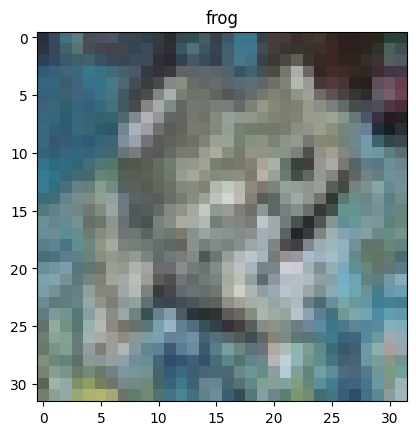

In [13]:
randimg = np.random.randint(len(X_train))
randlab = y_train[randimg]
randlab = np.where(randlab == 1)
# print(randlab[0][0])
plt.title(classes[randlab[0][0]])
plt.imshow(X_train[randimg])

### Training

In [14]:
checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/Researchs/SGAN_checkpoint.h5'

# model_checkpoint_callback = ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)

# history = model.fit(X_train, y_train,
#                     epochs=100, batch_size = 16,
#                     validation_data = (X_test, y_test),
#                     verbose=1,)
#                     # callbacks=[model_checkpoint_callback])

In [15]:
# model.save(checkpoint_filepath)

### Evaluating


In [16]:
# # plt.figure()
# fig, ax = plt.subplots(1,2,figsize=(12,7))
# ax[0].plot(history.history['loss'], color='b', label="Training Loss")
# legend = ax[0].legend(loc='best', shadow=True)
# ax[1].plot(history.history['categorical_accuracy'], color='b', label="Training Accuracy")
# legend = ax[1].legend(loc='best', shadow=True)

# ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss")
# legend = ax[0].legend(loc='best', shadow=True)
# ax[1].plot(history.history['val_categorical_accuracy'], color='r', label="Validation Accuracy")
# legend = ax[1].legend(loc='best', shadow=True)

In [17]:
# from keras.src.datasets.cifar10 import load_data
# from keras.models import load_model

# my_model = load_model('/content/drive/MyDrive/Colab Notebooks/Researchs/SGAN_checkpoint.h5')

# (_,_), (x_ev, y_ev) = load_data()

# x_ev = x_ev/255.
# y_ev = tf.one_hot(y_ev.astype(np.int32), depth=10)

# y_ev = np.squeeze(y_ev)
# print(x_ev.shape)
# print(y_ev.shape)

# _, test_acc = my_model.evaluate(x_ev, y_ev, verbose=1)
# print('Test acc: %.3f%%' % (test_acc*100))

In [18]:
# import seaborn as sns
# # Predict the values from the validation dataset
# y_pred = model.predict(x_ev)
# # Convert predictions classes to one hot vectors
# y_pred_classes = np.argmax(y_pred,axis = 1)
# # Convert validation observations to one hot vectors
# y_true = np.argmax(y_ev,axis = 1)
# # compute the confusion matrix
# confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_classes)

# plt.figure(figsize=(12, 9))
# c = sns.heatmap(confusion_mtx, annot=True, fmt='g')
# c.set(xticklabels=classes, yticklabels=classes)

## Custom training loop for more sensitive investigations

#### Model

In [19]:
def cifar_cnn(input_shape=(32,32,3), n_classes=10):
  input = Input(shape=input_shape)

  x = Conv2D(32, (3,3), strides=(2,2), padding='same', activation='relu')(input)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)

  x = Conv2D(64, (3,3), strides=(2,2), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)

  x = Conv2D(128, (3,3), strides=(2,2), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)

  x = Conv2D(256, (3,3), strides=(2,2), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  # x = Dropout(0.2)(x)

  x = Flatten()(x)
  x = Dropout(0.6)(x)

  x = Dense(100, activation='relu')(x)
  output = Dense(n_classes, activation='softmax')(x)

  model = Model(input,output)
  return model

cifar_cnn_model = cifar_cnn()
cifar_cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 32)        896       
                                                                 
 batch_normalization_4 (Bat  (None, 16, 16, 32)        128       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 batch_normalization_5 (Bat  (None, 8, 8, 64)          256       
 chNormalization)                                            

In [20]:
randimg = np.random.randn(1,32,32,3)
print(randimg.shape)
cifar_cnn_model.predict(randimg)

(1, 32, 32, 3)
1/1 [==============================] - 0s 428ms/step


array([[0.09740261, 0.10528267, 0.08957164, 0.09776793, 0.10305175,
        0.09918594, 0.10085328, 0.09985811, 0.10494501, 0.10208101]],
      dtype=float32)

In [21]:
loss_fn = CategoricalCrossentropy(from_logits=False)
metric = CategoricalAccuracy()
n_epochs = 100
batch_size = 16

#### Custom training and validation block

In [22]:
# @tf.function
def training_block(x_batch, y_batch, model, optimizer):
  with tf.GradientTape() as tape:
    y_pred = model(x_batch, training=True)
    loss = loss_fn(y_batch, y_pred)

  gradients = tape.gradient(loss, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))
  metric.update_state(y_batch, y_pred)

  return loss

# @tf.function
def val_block(x_batch_val, y_batch_val, model, optimizer):
  y_pred_val = model(x_batch_val, training=False)
  loss_val = loss_fn(y_batch_val, y_pred_val)
  metric.update_state(y_batch_val, y_pred_val)

  return loss_val

In [23]:
class TrainStep(tf.Module):
  def __init__(self, optimizer):
    self.optimizer = optimizer

  @tf.function
  def __call__(self, x_batch, y_batch, model):
    with tf.GradientTape() as tape:
      y_pred = model(x_batch, training=True)
      loss = loss_fn(y_batch, y_pred)

    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    metric.update_state(y_batch, y_pred)

    return loss

class ValStep(tf.Module):
  def __init__(self, optimizer):
    self.optimizer = optimizer

  @tf.function
  def __call__(self, x_batch_val, y_batch_val, model):
    y_pred_val = model(x_batch_val, training=False)
    loss_val = loss_fn(y_batch_val, y_pred_val)
    metric.update_state(y_batch_val, y_pred_val)

    return loss_val


#### Training

In [24]:
import sys

def cifar_cnn_train(lr):
  # Data prep
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 0.2)
  y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
  y_test = tf.one_hot(y_test.astype(np.int32), depth=10)
  batch_len = int(len(X_train)/batch_size)

  # Model Define
  cifar_model = cifar_cnn()
  optimizer = Adam(learning_rate=lr, beta_1=.5)
  # train_step = TrainStep(optimizer)
  # val_step = ValStep(optimizer)

  train_loss_temp, train_acc_temp, val_loss_temp, val_acc_temp = [], [], [], []

  # Epoch training
  for epoch in range(n_epochs):
    batch_loss_train = np.zeros(batch_len)
    batch_loss_val = np.zeros(batch_len)

    # Batch training
    for batch in range(batch_len):
      x_batch_train = X_train[batch*batch_len:(batch+1)*batch_len]
      y_batch_train = y_train[batch*batch_len:(batch+1)*batch_len]
      train_loss = train_step(x_batch_train, y_batch_train, cifar_model, optimizer)
      batch_loss_train[batch] = train_loss

    train_loss_temp.append(np.mean(batch_loss_train))
    train_acc_temp.append(metric.result().numpy())
    # print('train acc: ', train_acc_temp[-1])
    metric.reset_states()

    # Batch validation
    for batch in range(batch_len):
      x_batch_val = X_test[batch*batch_len:(batch+1)*batch_len]
      y_batch_val = y_test[batch*batch_len:(batch+1)*batch_len]
      val_loss = val_step(x_batch_val, y_batch_val, cifar_model, optimizer)
      batch_loss_val[batch] = val_loss

    val_loss_temp.append(np.mean(batch_loss_val))
    val_acc_temp.append(metric.result().numpy())
    # print('val acc: ', val_acc_temp[-1])
    metric.reset_states()

  train_loss_avg = np.mean(train_loss_temp[-10:])
  train_acc_avg = np.mean(train_acc_temp[-10:])*100
  val_loss_avg = np.mean(val_loss_temp[-10:])
  val_acc_avg = np.mean(val_acc_temp[-10:])*100

  sys.stdout.write(f'\r>{idx+1}/{len(lrs)} Trained on lr: {lr}, train_loss: %.3f, train_acc: %.3f%%, val_loss: %.3f, val_acc: %.3f%%' % (train_loss_avg, train_acc_avg, val_loss_avg, val_acc_avg))

  return train_loss_avg, train_acc_avg, val_loss_avg, val_acc_avg

In [25]:
# lrs = np.linspace(.00002, .002, 20)
# train_losses, train_acc, val_losses, val_acc = [], [], [], []

# for idx, lr in enumerate(lrs):
#   train_step = tf.function(training_block)
#   val_step = tf.function(val_block)

#   train_loss_avg, train_acc_avg, val_loss_avg, val_acc_avg = cifar_cnn_train(lr)

#   train_losses.append(train_loss_avg)
#   train_acc.append(train_acc_avg)
#   val_losses.append(val_loss_avg)
#   val_acc.append(val_acc_avg)

#### Evaluating

In [26]:
# fig,ax = plt.subplots(1,2,figsize=(13,4))

# ax[0].plot(train_losses,'o-',label='Train')
# ax[0].plot(val_losses,'o-',label='Test')
# ax[0].set_ylabel('Loss')
# ax[0].set_xlabel('Lr')
# ax[0].set_title('Losses')
# ax[0].legend()

# ax[1].plot(train_acc,'o-',label='Train')
# ax[1].plot(val_acc,'o-',label='Test')
# ax[1].set_ylabel('Accuracy (%)')
# ax[1].set_xlabel('Lr')
# ax[1].set_title('Accuracy')
# ax[1].legend()
# plt.show()

## PyTorch modelling

#### Dataset converting for PyTorch

In [27]:
train_data_torch, test_data_torch, train_label_torch, test_label_torch = train_test_split(X, Y, test_size=.2)
train_data_torch = torch.tensor(train_data_torch).float()
test_data_torch = torch.tensor(test_data_torch).float()

train_data_torch = torch.permute(train_data_torch, (0,3,1,2))
test_data_torch = torch.permute(test_data_torch, (0,3,1,2))

train_label_torch = torch.tensor(train_label_torch).long()
test_label_torch = torch.tensor(test_label_torch).long()
print(train_data_torch.shape, train_label_torch.shape)
print(test_data_torch.shape, test_label_torch.shape)
print()

train_data_torch = TensorDataset(train_data_torch, train_label_torch)
test_data_torch = TensorDataset(test_data_torch, test_label_torch)
print(train_data_torch.tensors[0].shape, train_data_torch.tensors[1].shape)
print(test_data_torch.tensors[0].shape, test_data_torch.tensors[1].shape)
print()

train_loader = DataLoader(train_data_torch, batch_size = 16, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data_torch, batch_size = test_data_torch.tensors[0].shape[0])
print(train_loader.dataset.tensors[0].shape, train_loader.dataset.tensors[1].shape)
print(test_loader.dataset.tensors[0].shape, test_loader.dataset.tensors[1].shape)

XX, yy = next(iter(train_loader))
print(XX.shape, yy.shape)

torch.Size([96, 3, 32, 32]) torch.Size([96])
torch.Size([24, 3, 32, 32]) torch.Size([24])

torch.Size([96, 3, 32, 32]) torch.Size([96])
torch.Size([24, 3, 32, 32]) torch.Size([24])

torch.Size([96, 3, 32, 32]) torch.Size([96])
torch.Size([24, 3, 32, 32]) torch.Size([24])
torch.Size([16, 3, 32, 32]) torch.Size([16])


In [28]:
# XX, yy = next(iter(train_loader))
# print('Batch data shape: ',XX.shape)
# print(net)
# print(lossfun)
# print(optimizer)
# y_pred = net(XX)
# print('Output shape: ', y_pred.shape)

#### Data Loading

In [29]:
transform = T.Compose([T.ToTensor(),
                       T.Normalize([.5,.5,.5], [.5,.5,.5])
                       ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
valset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

print(trainset.data.shape, valset.data.shape)
print()

batchsize = 32
train_loader_full = DataLoader(trainset, batch_size=batchsize,shuffle=True, drop_last=True)
val_loader_full = DataLoader(valset, batch_size=batch_size)

print(train_loader_full.dataset.data.shape, val_loader_full.dataset.data.shape)

Files already downloaded and verified
Files already downloaded and verified
(50000, 32, 32, 3) (10000, 32, 32, 3)

(50000, 32, 32, 3) (10000, 32, 32, 3)


#### Model

In [30]:
# create a class for the model
def createTheCifarNet(learningrate):

  class cifarNet(nn.Module):
    def __init__(self):
      super().__init__()

      # first conv
      self.conv1 = nn.Conv2d(3, 32, 3, padding=1, stride=2)
      self.bnorm1 = nn.BatchNorm2d(32) # input the number of channels in this layer
      self.dropout1 = nn.Dropout2d(.2)
      # ouput size: (32 + 2 - 3) / 2 + 1 = 16
      outsize = np.floor((32 + 2 - 3) / 2) + 1

      # second conv
      self.conv2 = nn.Conv2d(32, 64, 3, padding=1, stride=2)
      self.bnorm2 = nn.BatchNorm2d(64)
      outsize = np.floor((outsize + 2 - 3) / 2) + 1

      # third conv
      self.conv3 = nn.Conv2d(64, 128, 3, padding=1, stride=2)
      self.bnorm3 = nn.BatchNorm2d(128)
      outsize = np.floor((outsize + 2 - 3) / 2) + 1

      # fourth conv
      self.conv4 = nn.Conv2d(128, 256, 3, padding=1, stride=2)
      self.bnorm4 = nn.BatchNorm2d(256)
      outsize = int(np.floor((outsize + 2 - 3) / 2) + 1)

      ### hidden layer
      self.flatten = nn.Flatten()
      self.fc1 = nn.Linear(outsize*outsize*256,100)
      self.dropout2 = nn.Dropout2d(.6)

      ### output layer
      self.output = nn.Linear(100,10)

    # forward pass
    def forward(self,x):
      x = F.relu(self.bnorm1(self.conv1(x)))
      x = self.dropout1(x)
      x = F.relu(self.bnorm2(self.conv2(x)))
      x = self.dropout1(x)
      x = F.relu(self.bnorm3(self.conv3(x)))
      x = self.dropout1(x)
      x = F.relu(self.bnorm4(self.conv4(x)))

      # x = F.relu(self.conv1(x))
      # x = self.dropout1(x)
      # x = F.relu(self.conv2(x))
      # x = self.dropout1(x)
      # x = F.relu(self.conv3(x))
      # x = self.dropout1(x)
      # x = F.relu(self.conv4(x))

      x = self.flatten(x)
      x = self.dropout2(x)
      x = F.relu(self.fc1(x))
      x = F.relu(self.output(x))
      return x

  # create the model instance
  net = cifarNet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=learningrate)

  return net,lossfun,optimizer

net, lossfun, optimizer = createTheCifarNet(.002)
summary(net, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             896
       BatchNorm2d-2           [-1, 32, 16, 16]              64
         Dropout2d-3           [-1, 32, 16, 16]               0
            Conv2d-4             [-1, 64, 8, 8]          18,496
       BatchNorm2d-5             [-1, 64, 8, 8]             128
         Dropout2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 4, 4]          73,856
       BatchNorm2d-8            [-1, 128, 4, 4]             256
         Dropout2d-9            [-1, 128, 4, 4]               0
           Conv2d-10            [-1, 256, 2, 2]         295,168
      BatchNorm2d-11            [-1, 256, 2, 2]             512
          Flatten-12                 [-1, 1024]               0
        Dropout2d-13                 [-1, 1024]               0
           Linear-14                  [

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


#### Training


In [31]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [32]:
# a function that trains the model

def function2trainTheModel(learningrate):

  # number of epochs
  numepochs = 200

  # create a new model
  net,lossfun,optimizer = createTheCifarNet(learningrate)
  net.to(device)

  # initialize losses
  losses    = np.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)

      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric).item() # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item() )
    sys.stdout.write(f'\r>{epochi}/{numepochs} loss avg: {losses[-1]:.3f}, train acc: {trainAcc[-1]:.3f}%, test acc: {testAcc[-1]:.3f}%')

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

In [33]:
import sys
import time

lrs = np.linspace(.00002, .002, 20)
trainAcc_arr,testAcc_arr,losses_arr = [], [], []

# trainAcc, testAcc, losses, net = function2trainTheModel(lrs[10])

# start_time = time.process_time()

# for idx, lr in enumerate(lrs):
#   loop_start_time = time.process_time()

#   trainAcc, testAcc, losses, net = function2trainTheModel(lr)
#   trainAcc_arr.append(np.mean(trainAcc[-10:]))
#   testAcc_arr.append(np.mean(testAcc[-10:]))
#   losses_arr.append(np.mean(losses[-10:]))

#   loop_end_time = time.process_time() - loop_start_time

#   sys.stdout.write(f'\r>{idx+1}/{len(lrs)} loss avg: %.3f, train acc: %.3f%%, test acc: %.3f%%, time: %.3f' % (np.mean(losses[-10:]), np.mean(trainAcc[-10:]), np.mean(testAcc[-10:]), loop_end_time))

# end_time = time.process_time() - start_time
# print(f'\nTotal time: {end_time:.3f}')

In [34]:
def model_evaluate(model, data_loader):
  model.eval()
  lossfun = nn.CrossEntropyLoss()

  with torch.no_grad():
    for x,y in data_loader:

      y_pred = model(x)
      loss = lossfun(y_pred, y)

      acc = 100*torch.mean((torch.argmax(y_pred, 1)==y).float()).item()
      print(acc)

In [35]:
model_evaluate(net, test_loader)

12.5


#### Plotting

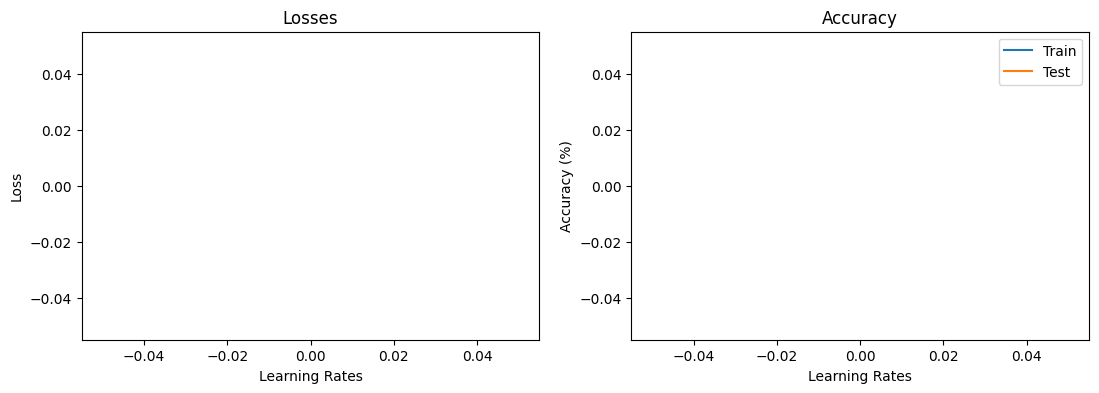

In [36]:
fig,ax = plt.subplots(1,2,figsize=(13,4))

ax[0].plot(losses_arr)
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Learning Rates')
ax[0].set_title('Losses')

ax[1].plot(trainAcc_arr,label='Train')
ax[1].plot(testAcc_arr,label='Test')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Learning Rates')
ax[1].set_title('Accuracy')
ax[1].legend()
plt.show()

In [37]:
# fig,ax = plt.subplots(1,2,figsize=(13,4))

# ax[0].plot(losses)
# ax[0].set_ylabel('Loss')
# # ax[0].set_ylim(.0, .5)
# ax[0].set_xlabel('Epochs')
# ax[0].set_title('Losses')

# ax[1].plot(trainAcc,label='Train')
# ax[1].plot(testAcc,label='Test')
# ax[1].set_ylabel('Accuracy (%)')
# ax[1].set_xlabel('Epochs')
# ax[1].set_title('Accuracy')
# ax[1].legend()
# plt.show()

In [39]:
# fig,ax = plt.subplots(1,2,figsize=(13,4))

# ax[0].plot(losses)
# ax[0].set_ylabel('Loss')
# # ax[0].set_ylim(.0, .5)
# ax[0].set_xlabel('Epochs')
# ax[0].set_title('Losses')

# ax[1].plot(trainAcc,label='Train')
# ax[1].plot(testAcc,label='Test')
# ax[1].set_ylabel('Accuracy (%)')
# ax[1].set_xlabel('Epochs')
# ax[1].set_title('Accuracy')
# ax[1].legend()
# plt.show()

## Build the Semi-Supervised GAN model for unlabelled datas

### Define the model

In [48]:
def define_generator(latent_vector, detail=False):
  input_latent = Input(shape=(latent_vector,))
  n_nodes = 4 * 4 * 256
  x = Dense(n_nodes)(input_latent)
  if detail: print(x.shape)
  x = LeakyReLU()(x)
  x = Reshape((4, 4, 256))(x) #4x4x256

  x = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same')(x) #8x8x128
  if detail: print(x.shape)
  x = LeakyReLU()(x)

  x = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same',)(x) #16x16x64
  if detail: print(x.shape)
  x = LeakyReLU()(x)

  #output
  output_layer = x = Conv2DTranspose(3, (3,3), strides=(2,2), padding='same', activation='tanh')(x) #32x32x3
  if detail: print(output_layer.shape)

  model = Model(input_latent, output_layer)

  return model

gen_model = define_generator(100, True)
gen_model.summary()

(None, 4096)
(None, 8, 8, 128)
(None, 16, 16, 64)
(None, 32, 32, 3)
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_7 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 8, 8, 128)         295040    
 Transpose)                                                      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 8, 8, 128)         0 

In [49]:
def define_discriminator(input_shape=(32,32,3), n_classes=10):
  input_layer = Input(input_shape)
  x = Conv2D(64, (3,3), strides=(2,2), padding='same')(input_layer)
  x = LeakyReLU()(x)

  x = Conv2D(128, (3,3), strides=(2,2), padding='same')(x)
  x = LeakyReLU()(x)

  x = Conv2D(256, (3,3), strides=(2,2), padding='same')(x)
  x = LeakyReLU()(x)

  x = Flatten()(x)
  x = Dropout(0.4)(x)
  x = Dense(100)(x)
  x = Dense(n_classes)(x)

  model = Model(input_layer, x)

  return model

disc_model = define_discriminator()
disc_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 64)        1792      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_13 (Conv2D)          (None, 4, 4, 256)         295168    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 4, 4, 256)         0   

In [50]:
def define_sup_discriminator(disc):
  model = Sequential()
  model.add(disc)
  model.add(Activation('softmax'))
  model.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
                loss = 'categorical_crossentropy', metrics=['categorical_accuracy'])
  return model

sup_disc_model = define_sup_discriminator(disc_model)
sup_disc_model.summary()

# sup_disc_model.evaluate(x_ev, y_ev)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_5 (Functional)        (None, 10)                781526    
                                                                 
 activation_1 (Activation)   (None, 10)                0         
                                                                 
Total params: 781526 (2.98 MB)
Trainable params: 781526 (2.98 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
def custom_activation(x):
  zx = K.sum(K.exp(x), axis=-1, keepdims=True)
  dx = zx/(zx+1)
  return dx

def define_unsup_discriminator(disc):
  model = Sequential()
  model.add(disc)
  model.add(Lambda(custom_activation))
  # model.add(Activation('sigmoid'))
  model.compile(optimizer=Adam(learning_rate=.0002, beta_1=0.5),
                loss = 'binary_crossentropy', metrics=['accuracy'])
  return model

unsup_disc_model = define_unsup_discriminator(disc_model)
unsup_disc_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_5 (Functional)        (None, 10)                781526    
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 781526 (2.98 MB)
Trainable params: 781526 (2.98 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
def define_gan(gen_model, disc_unsup):
  disc_unsup.trainable = False #make unsup. discriminator not trainable
  gan_output = disc_unsup(gen_model.output) #Gen. output is the input to disc.

  model = Model(gen_model.input, gan_output)
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=.0002, beta_1=.5))
  return model

gan_model = define_gan(gen_model,unsup_disc_model)
gan_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_7 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 8, 8, 128)         295040    
 Transpose)                                                      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                           

### Data prepration

In [45]:
def load_real_samples(n_classes=10):
  (trainX, trainy), (_, _) = cifar10.load_data()
  # X = expand_dims(trainX, axis=-1)
  X = trainX.astype('float32')
  X = (X - 127.5) / 127.5  # scale from [0,255] to [-1,1] as we will be using tanh activation.
  print(X.shape, trainy.shape)
  return [X, trainy]

def generate_real_samples(dataset, n_samples):
  images, labels = dataset
  ix = np.random.randint(0, images.shape[0], n_samples)
  X, labels = images[ix], labels[ix]
  y = np.ones((n_samples,1))
  return [X, labels], y

real_samples = generate_real_samples(dataset, 100)
print(real_samples[1].shape)

def generate_latent_points(latent_dim, n_samples):
  z_input = np.random.randn(latent_dim * n_samples)
  z_input = z_input.reshape(n_samples, latent_dim)
  return z_input

z_input = generate_latent_points(100, 100)
print(z_input.shape)

def generate_fake_samples(generator, latent_dim, n_samples):
  z_input = generate_latent_points(latent_dim, n_samples)
  fake_images = generator.predict(z_input)

  y = np.zeros((n_samples,1))
  return fake_images, y

# fake_samples = generate_fake_samples(gen_model, 100, 100)
# print(fake_samples[0].shape)

def summarize_performance(stop, gen_model, disc_sup, latent_dim, dataset, n_samples=100):
  #Generate fake images
  X, _ = generate_fake_samples(gen_model, latent_dim, n_samples)
  X = (X + 1) / 2.0

  plt.figure(figsize=(15,10))
  #plot images
  for i in range(n_samples):
    plt.subplot(10,10,i+1)
    plt.axis('off')
    plt.imshow(X[i,:,:,0], cmap='gray_r')

  filename1 = '/content/drive/MyDrive/Colab Notebooks/Researchs/generated_plot2.png'
  # plt.savefig(filename1)
  plt.close()

  #evaluate the discriminate
  X,y = dataset
  y = tf.one_hot(y.astype(np.int32), depth=10)
  y = np.squeeze(y)
  _, acc = disc_sup.evaluate(X, y, verbose=0)
  print('Discriminator Accuracy: %.3f%%' % (acc * 100))

  filename2 = '/content/drive/MyDrive/Colab Notebooks/Researchs/gen_model2.h5'
  gen_model.save(filename2)
  filename3 = '/content/drive/MyDrive/Colab Notebooks/Researchs/disc_sup2.h5'
  disc_sup.save(filename3)
  print('>Saved: %s %s, and %s' % (filename1, filename2, filename3))

# summarize_performance(0, gen_model, sup_disc_model, 100, dataset)

(100, 1)
(100, 100)


### Training

In [53]:
def train(gen_model, disc_unsup, disc_sup, gan_model, dataset, latent_dim, n_epochs=20, n_batch=100):
  X_sup, y_sup = select_subset_images(dataset, n_samples = 100, n_classes=10)
  y_sup = tf.one_hot(y_sup.astype(np.int32), depth=10)
  y_sup = np.squeeze(y_sup)
  print(X_sup.shape, y_sup.shape)

  bat_per_epo = int(dataset[0].shape[0]/n_batch)
  n_steps = bat_per_epo * n_epochs

  half_batch = int(n_batch/2)
  print('n_epochs=%d, n_batch=%d, half_batch=%d, bat_per_epo=%d, steps=%d' % (n_epochs, n_batch, half_batch, bat_per_epo, n_steps))

  #enumerate epochs
  for i in range(n_steps):
    #supervised discriminator on real samples
    [Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], half_batch)
    sup_loss, sup_acc = disc_sup.train_on_batch(Xsup_real, ysup_real)

    #unsupervised discriminator
    [X_real, _], y_real = generate_real_samples(dataset, half_batch)
    # print(y_real)
    d_loss_real = disc_unsup.train_on_batch(X_real, y_real)

    #train fake
    X_fake, y_fake = generate_fake_samples(gen_model, latent_dim, half_batch)
    d_loss_fake = disc_unsup.train_on_batch(X_fake, y_fake)

    #upadete generator(gen)
    X_gan, y_gan = generate_latent_points(latent_dim, n_batch), np.ones((n_batch,1))
    gan_loss = gan_model.train_on_batch(X_gan, y_gan)

    #summarize loss on this batch
    print(f'>{i+1}, supervised[loss: %.3f, acc: %.3f%%], disc[disc loss real: %.3f, disc loss fake: %.3f], gan[gan loss: %.3f]' % (sup_loss, sup_acc*100, d_loss_real[0], d_loss_fake[0], gan_loss))
    #evaluate the model performance periodically
    if (i+1)%(bat_per_epo*1) == 0:
      summarize_performance(i, gen_model, disc_sup, latent_dim, dataset)

# sup_disc_model.summary()
dataset_norm_gan = load_real_samples()
train(gen_model, unsup_disc_model, sup_disc_model, gan_model, dataset_norm_gan, 100)

(50000, 32, 32, 3) (50000, 1)
100
100
(100, 32, 32, 3) (100, 10)
n_epochs=20, n_batch=100, half_batch=50, bat_per_epo=500, steps=10000
2/2 [==============================] - 0s 37ms/step
>1, supervised[loss: 2.318, acc: 10.000%], disc[disc loss real: 0.095, disc loss fake: 2.403], gan[gan loss: 0.095]
2/2 [==============================] - 0s 26ms/step
>2, supervised[loss: 2.272, acc: 18.000%], disc[disc loss real: 0.089, disc loss fake: 2.400], gan[gan loss: 0.095]
2/2 [==============================] - 0s 22ms/step
>3, supervised[loss: 2.260, acc: 20.000%], disc[disc loss real: 0.085, disc loss fake: 2.397], gan[gan loss: 0.096]
2/2 [==============================] - 0s 21ms/step
>4, supervised[loss: 2.259, acc: 16.000%], disc[disc loss real: 0.078, disc loss fake: 2.392], gan[gan loss: 0.096]
2/2 [==============================] - 0s 21ms/step
>5, supervised[loss: 2.153, acc: 30.000%], disc[disc loss real: 0.066, disc loss fake: 2.387], gan[gan loss: 0.097]
2/2 [====================

Discriminator Accuracy: 10.000%
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/generated_plot2.png /content/drive/MyDrive/Colab Notebooks/Researchs/gen_model2.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/disc_sup2.h5
2/2 [==============================] - 0s 36ms/step
>501, supervised[loss: nan, acc: 6.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 40ms/step
>502, supervised[loss: nan, acc: 10.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 24ms/step
>503, supervised[loss: nan, acc: 18.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 22ms/step
>504, supervised[loss: nan, acc: 14.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 24ms/step
>505, supervised[loss: nan, acc: 12.000%], disc[disc loss real

Discriminator Accuracy: 10.000%
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/generated_plot2.png /content/drive/MyDrive/Colab Notebooks/Researchs/gen_model2.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/disc_sup2.h5
2/2 [==============================] - 0s 23ms/step
>1001, supervised[loss: nan, acc: 10.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 22ms/step
>1002, supervised[loss: nan, acc: 18.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 25ms/step
>1003, supervised[loss: nan, acc: 4.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 26ms/step
>1004, supervised[loss: nan, acc: 6.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 22ms/step
>1005, supervised[loss: nan, acc: 4.000%], disc[disc loss r

Discriminator Accuracy: 10.000%
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/generated_plot2.png /content/drive/MyDrive/Colab Notebooks/Researchs/gen_model2.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/disc_sup2.h5
2/2 [==============================] - 0s 24ms/step
>1501, supervised[loss: nan, acc: 8.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 24ms/step
>1502, supervised[loss: nan, acc: 8.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 23ms/step
>1503, supervised[loss: nan, acc: 6.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 24ms/step
>1504, supervised[loss: nan, acc: 18.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 24ms/step
>1505, supervised[loss: nan, acc: 2.000%], disc[disc loss re

Discriminator Accuracy: 10.000%
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/generated_plot2.png /content/drive/MyDrive/Colab Notebooks/Researchs/gen_model2.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/disc_sup2.h5
2/2 [==============================] - 0s 25ms/step
>2001, supervised[loss: nan, acc: 8.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 30ms/step
>2002, supervised[loss: nan, acc: 8.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 32ms/step
>2003, supervised[loss: nan, acc: 12.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 26ms/step
>2004, supervised[loss: nan, acc: 6.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 25ms/step
>2005, supervised[loss: nan, acc: 10.000%], disc[disc loss r

Discriminator Accuracy: 10.000%
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/generated_plot2.png /content/drive/MyDrive/Colab Notebooks/Researchs/gen_model2.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/disc_sup2.h5
2/2 [==============================] - 0s 27ms/step
>2501, supervised[loss: nan, acc: 8.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 26ms/step
>2502, supervised[loss: nan, acc: 10.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 26ms/step
>2503, supervised[loss: nan, acc: 4.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 25ms/step
>2504, supervised[loss: nan, acc: 4.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 28ms/step
>2505, supervised[loss: nan, acc: 4.000%], disc[disc loss re

Discriminator Accuracy: 10.000%
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/generated_plot2.png /content/drive/MyDrive/Colab Notebooks/Researchs/gen_model2.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/disc_sup2.h5
2/2 [==============================] - 0s 26ms/step
>3001, supervised[loss: nan, acc: 10.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 25ms/step
>3002, supervised[loss: nan, acc: 16.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 25ms/step
>3003, supervised[loss: nan, acc: 12.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 28ms/step
>3004, supervised[loss: nan, acc: 6.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 26ms/step
>3005, supervised[loss: nan, acc: 6.000%], disc[disc loss 

Discriminator Accuracy: 10.000%
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/generated_plot2.png /content/drive/MyDrive/Colab Notebooks/Researchs/gen_model2.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/disc_sup2.h5
2/2 [==============================] - 0s 27ms/step
>3501, supervised[loss: nan, acc: 6.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 26ms/step
>3502, supervised[loss: nan, acc: 14.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 28ms/step
>3503, supervised[loss: nan, acc: 0.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 36ms/step
>3504, supervised[loss: nan, acc: 18.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 27ms/step
>3505, supervised[loss: nan, acc: 18.000%], disc[disc loss 

Discriminator Accuracy: 10.000%
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/generated_plot2.png /content/drive/MyDrive/Colab Notebooks/Researchs/gen_model2.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/disc_sup2.h5
2/2 [==============================] - 0s 32ms/step
>4001, supervised[loss: nan, acc: 14.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 27ms/step
>4002, supervised[loss: nan, acc: 4.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 30ms/step
>4003, supervised[loss: nan, acc: 8.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 46ms/step
>4004, supervised[loss: nan, acc: 10.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 49ms/step
>4005, supervised[loss: nan, acc: 2.000%], disc[disc loss r

Discriminator Accuracy: 10.000%
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/generated_plot2.png /content/drive/MyDrive/Colab Notebooks/Researchs/gen_model2.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/disc_sup2.h5
2/2 [==============================] - 0s 28ms/step
>4501, supervised[loss: nan, acc: 10.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 31ms/step
>4502, supervised[loss: nan, acc: 2.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 29ms/step
>4503, supervised[loss: nan, acc: 12.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 28ms/step
>4504, supervised[loss: nan, acc: 16.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 28ms/step
>4505, supervised[loss: nan, acc: 6.000%], disc[disc loss 

Discriminator Accuracy: 10.000%
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/generated_plot2.png /content/drive/MyDrive/Colab Notebooks/Researchs/gen_model2.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/disc_sup2.h5
2/2 [==============================] - 0s 30ms/step
>5001, supervised[loss: nan, acc: 4.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 27ms/step
>5002, supervised[loss: nan, acc: 4.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 48ms/step
>5003, supervised[loss: nan, acc: 4.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 31ms/step
>5004, supervised[loss: nan, acc: 12.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 27ms/step
>5005, supervised[loss: nan, acc: 12.000%], disc[disc loss r

Discriminator Accuracy: 10.000%
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/generated_plot2.png /content/drive/MyDrive/Colab Notebooks/Researchs/gen_model2.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/disc_sup2.h5
2/2 [==============================] - 0s 34ms/step
>5501, supervised[loss: nan, acc: 12.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 42ms/step
>5502, supervised[loss: nan, acc: 2.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 29ms/step
>5503, supervised[loss: nan, acc: 6.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 29ms/step
>5504, supervised[loss: nan, acc: 10.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 31ms/step
>5505, supervised[loss: nan, acc: 16.000%], disc[disc loss 

Discriminator Accuracy: 10.000%
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/generated_plot2.png /content/drive/MyDrive/Colab Notebooks/Researchs/gen_model2.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/disc_sup2.h5
2/2 [==============================] - 0s 30ms/step
>6001, supervised[loss: nan, acc: 8.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 28ms/step
>6002, supervised[loss: nan, acc: 6.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 28ms/step
>6003, supervised[loss: nan, acc: 18.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 30ms/step
>6004, supervised[loss: nan, acc: 14.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 29ms/step
>6005, supervised[loss: nan, acc: 4.000%], disc[disc loss r

Discriminator Accuracy: 10.000%
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/generated_plot2.png /content/drive/MyDrive/Colab Notebooks/Researchs/gen_model2.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/disc_sup2.h5
2/2 [==============================] - 0s 30ms/step
>6501, supervised[loss: nan, acc: 12.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 31ms/step
>6502, supervised[loss: nan, acc: 4.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 41ms/step
>6503, supervised[loss: nan, acc: 10.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 31ms/step
>6504, supervised[loss: nan, acc: 14.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 35ms/step
>6505, supervised[loss: nan, acc: 16.000%], disc[disc loss

Discriminator Accuracy: 10.000%
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/generated_plot2.png /content/drive/MyDrive/Colab Notebooks/Researchs/gen_model2.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/disc_sup2.h5
2/2 [==============================] - 0s 29ms/step
>7001, supervised[loss: nan, acc: 16.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 30ms/step
>7002, supervised[loss: nan, acc: 10.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 28ms/step
>7003, supervised[loss: nan, acc: 10.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 36ms/step
>7004, supervised[loss: nan, acc: 10.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 31ms/step
>7005, supervised[loss: nan, acc: 6.000%], disc[disc loss

Discriminator Accuracy: 10.000%
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/generated_plot2.png /content/drive/MyDrive/Colab Notebooks/Researchs/gen_model2.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/disc_sup2.h5
2/2 [==============================] - 0s 30ms/step
>7501, supervised[loss: nan, acc: 8.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 30ms/step
>7502, supervised[loss: nan, acc: 12.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 32ms/step
>7503, supervised[loss: nan, acc: 4.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 31ms/step
>7504, supervised[loss: nan, acc: 8.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 30ms/step
>7505, supervised[loss: nan, acc: 8.000%], disc[disc loss re

Discriminator Accuracy: 10.000%
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/generated_plot2.png /content/drive/MyDrive/Colab Notebooks/Researchs/gen_model2.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/disc_sup2.h5
2/2 [==============================] - 0s 35ms/step
>8001, supervised[loss: nan, acc: 8.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 30ms/step
>8002, supervised[loss: nan, acc: 20.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 35ms/step
>8003, supervised[loss: nan, acc: 6.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 34ms/step
>8004, supervised[loss: nan, acc: 10.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 37ms/step
>8005, supervised[loss: nan, acc: 10.000%], disc[disc loss 

Discriminator Accuracy: 10.000%
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/generated_plot2.png /content/drive/MyDrive/Colab Notebooks/Researchs/gen_model2.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/disc_sup2.h5
2/2 [==============================] - 0s 29ms/step
>8501, supervised[loss: nan, acc: 4.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 32ms/step
>8502, supervised[loss: nan, acc: 8.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 37ms/step
>8503, supervised[loss: nan, acc: 12.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 29ms/step
>8504, supervised[loss: nan, acc: 4.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 47ms/step
>8505, supervised[loss: nan, acc: 8.000%], disc[disc loss re

Discriminator Accuracy: 10.000%
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/generated_plot2.png /content/drive/MyDrive/Colab Notebooks/Researchs/gen_model2.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/disc_sup2.h5
2/2 [==============================] - 0s 28ms/step
>9001, supervised[loss: nan, acc: 6.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 32ms/step
>9002, supervised[loss: nan, acc: 6.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 31ms/step
>9003, supervised[loss: nan, acc: 6.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 31ms/step
>9004, supervised[loss: nan, acc: 10.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 38ms/step
>9005, supervised[loss: nan, acc: 8.000%], disc[disc loss re

Discriminator Accuracy: 10.000%
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/generated_plot2.png /content/drive/MyDrive/Colab Notebooks/Researchs/gen_model2.h5, and /content/drive/MyDrive/Colab Notebooks/Researchs/disc_sup2.h5
2/2 [==============================] - 0s 32ms/step
>9501, supervised[loss: nan, acc: 10.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 29ms/step
>9502, supervised[loss: nan, acc: 6.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 36ms/step
>9503, supervised[loss: nan, acc: 16.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 27ms/step
>9504, supervised[loss: nan, acc: 6.000%], disc[disc loss real: nan, disc loss fake: nan], gan[gan loss: nan]
2/2 [==============================] - 0s 29ms/step
>9505, supervised[loss: nan, acc: 8.000%], disc[disc loss r

KeyboardInterrupt: ignored

### Plotting

(10000, 10)
(10000, 32, 32, 3)
313/313 [==============================] - 6s 18ms/step - loss: 5.4346 - categorical_accuracy: 0.1638
Test Accuracy: 16.380%
313/313 [==============================] - 7s 23ms/step


<Axes: >

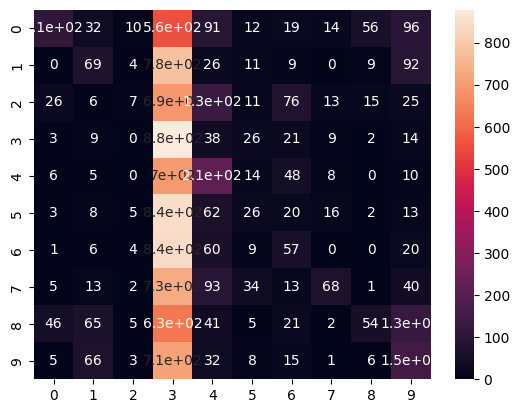

In [45]:
disc_sup_trained_model = load_model('/content/drive/MyDrive/Colab Notebooks/Researchs/disc_sup2.h5')
(_, _), (testX, testY) = cifar10.load_data()

testX = (testX - 127.5) / 127.5
testY = tf.one_hot(testY.astype(np.int32), depth=10)
testY = np.squeeze(testY)
print(testY.shape)
print(testX.shape)

_, test_acc = disc_sup_trained_model.evaluate(testX, testY)
print('Test Accuracy: %.3f%%' % (test_acc * 100))

y_pred_test = disc_sup_trained_model.predict(testX)
prediction_test = np.argmax(y_pred_test, axis=1)
y_true = np.argmax(testY, axis=1)

confusion_mtx = tf.math.confusion_matrix(y_true, prediction_test)
sns.heatmap(confusion_mtx, annot=True)

1/1 [==============================] - 0s 143ms/step


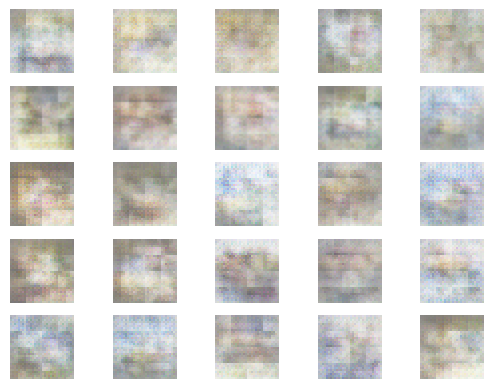

In [46]:
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :], cmap='gray')
	plt.show()

# load model
gen_trained_model = load_model('/content/drive/MyDrive/Colab Notebooks/Researchs/gen_model2.h5') #Model trained for 100 epochs
# generate images
latent_points = generate_latent_points(100, 25)  #Latent dim and n_samples
# generate images
X = gen_trained_model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

X = (X*255).astype(np.uint8)

# plot the result
show_plot(X, 5)

## Build the Semi-Supervised GAN model for unlabelled datas with PyTorch

### Model

#### Generator

In [ ]:
class Generator(nn.Module):
  def __init__(self, latent_vector):
      super(Generator, self).__init__()
      n_nodes = 4 * 4 * 256

      self.fc = nn.Sequential(
          nn.Linear(latent_vector, n_nodes),
          nn.LeakyReLU(0.2),
      )

      self.deconv1 = nn.Sequential(
          nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
          nn.LeakyReLU(0.2),
      )

      self.deconv2 = nn.Sequential(
          nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
          nn.LeakyReLU(0.2),
      )

      self.output_layer = nn.Sequential(
          nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
          nn.Tanh(),
      )

  def forward(self, input_latent, detail=False):
      x = self.fc(input_latent)
      if detail: print(x.shape)
      x = x.view(-1, 256, 4, 4)
      x = self.deconv1(x)
      if detail: print(x.shape)
      x = self.deconv2(x)
      if detail: print(x.shape)
      output_layer = self.output_layer(x)
      if detail: print(output_layer.shape)
      return output_layer

# Define the generator model with a latent vector size of 100
latent_vector_size = 100
define_gen_model = Generator(latent_vector_size)
# print(gen_model)
# summary(gen_model, (latent_vector_size,))
image = define_gen_model(torch.Tensor(100,latent_vector_size), True)
print(image.shape)

torch.Size([100, 4096])
torch.Size([100, 128, 8, 8])
torch.Size([100, 64, 16, 16])
torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])


#### Discriminator

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, input_shape=(3,32,32), n_classes=10):
    super(Discriminator, self).__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(input_shape[0], 64, kernel_size=3, stride=2, padding=1),
        nn.LeakyReLU(.3)
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
        nn.LeakyReLU(.3)
    )

    self.conv3 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
        nn.LeakyReLU(.3)
    )

    self.flatten = nn.Flatten()

    self.fc1 = nn.Sequential(
        nn.Linear(256 * 4 * 4, 100),
        nn.LeakyReLU(.3),
        nn.Dropout(.6)
    )

    self.fc2 = nn.Sequential(
        nn.Linear(100, n_classes)
    )

  def forward(self, input_shape):
    x = self.conv1(input_shape)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.fc2(x)

    return x

disc_model = Discriminator()
print(disc_model)
summary(disc_model, (3,32,32))

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.3)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.3)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.3)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Sequential(
    (0): Linear(in_features=4096, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.3)
    (2): Dropout(p=0.6, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           1,792
         LeakyReLU-2           [-1, 64, 16, 16]               0
   

#### Supervised Discriminator

In [ ]:
def define_supervised_disc(disc):
  class SupDiscriminator(nn.Module):
    def __init__(self, disc):
      super(SupDiscriminator, self).__init__()

      self.disc = disc
      self.softmax = nn.Softmax(1)

    def forward(self, input_layer):
      x = self.disc(input_layer)
      x = self.softmax(x)
      return x

  net = SupDiscriminator(disc)
  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(net.parameters(), lr=.0002)

  return net, lossfun, optimizer

define_sup_disc,lossfun_sup_dic,optimizer_sup_disc = define_supervised_disc(disc_model)
print(define_sup_disc)
summary(define_sup_disc, (3,32,32))

SupDiscriminator(
  (disc): Discriminator(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.3)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.3)
    )
    (conv3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.3)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Sequential(
      (0): Linear(in_features=4096, out_features=100, bias=True)
      (1): LeakyReLU(negative_slope=0.3)
      (2): Dropout(p=0.6, inplace=False)
    )
    (fc2): Sequential(
      (0): Linear(in_features=100, out_features=10, bias=True)
    )
  )
  (softmax): Softmax(dim=1)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         

In [ ]:
model_evaluate(define_sup_disc, test_loader)

4.16666679084301


#### Unsupervised Discriminator

In [ ]:
class CustomActivation(nn.Module):
  def __init__(self):
    super(CustomActivation, self).__init__()

  def forward(self, x):
    zx = torch.sum(torch.exp(x), dim=-1, keepdim=True)
    return zx/(zx+1)

def define_unsupervised_disc(disc):
  class UnsupDiscriminator(nn.Module):
    def __init__(self, disc):
      super(UnsupDiscriminator, self).__init__()

      self.disc = disc
      self.activation = CustomActivation()

    def forward(self, x):
      x = self.disc(x)
      x = self.activation(x)
      return x

  net = UnsupDiscriminator(disc)
  lossfun = nn.BCELoss()
  optimizer = torch.optim.Adam(net.parameters(), lr=.0002)

  return net, lossfun, optimizer

define_unsup_disc, lossfun_unsup_disc, optimizer_unsup_disc = define_unsupervised_disc(disc_model)
print(define_unsup_disc)
summary(define_unsup_disc, (3,32,32))

UnsupDiscriminator(
  (disc): Discriminator(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.3)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.3)
    )
    (conv3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.3)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Sequential(
      (0): Linear(in_features=4096, out_features=100, bias=True)
      (1): LeakyReLU(negative_slope=0.3)
      (2): Dropout(p=0.6, inplace=False)
    )
    (fc2): Sequential(
      (0): Linear(in_features=100, out_features=10, bias=True)
    )
  )
  (activation): CustomActivation()
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1

#### GAN

In [ ]:
def define_gan(gen, disc_unsup, detail=False):
  class GAN(nn.Module):
    def __init__(self, gen, disc_unsup, detail):
      super(GAN, self).__init__()

      self.gen = gen
      self.disc_unsup = disc_unsup
      self.disc_unsup.eval()

    def forward(self, x):
      if detail: print('input shape:', x.shape)
      fake_image = self.gen(x)
      if detail: print('gen output shape:', x.shape)
      x = self.disc_unsup(fake_image)
      if detail: print('disc unsup output shape:', x.shape)
      return fake_image, x

  net = GAN(gen, disc_unsup, detail)
  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(net.parameters(), lr=.0002)

  return net, lossfun, optimizer

gan_model, lossfun_gan, optimizer_gan = define_gan(define_gen_model, define_unsup_disc)
print(gan_model)
summary(gan_model, (100,))

GAN(
  (gen): Generator(
    (fc): Sequential(
      (0): Linear(in_features=100, out_features=4096, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (deconv1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
    )
    (deconv2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
    )
    (output_layer): Sequential(
      (0): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): Tanh()
    )
  )
  (disc_unsup): UnsupDiscriminator(
    (disc): Discriminator(
      (conv1): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.3)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2

### Data prepration

In [ ]:
def generate_real_samples(dataset, n_samples):
  images, labels = dataset
  ix = np.random.randint(0, images.shape[0], n_samples)
  X, labels = images[ix], labels[ix]
  y = torch.ones((n_samples))
  X = torch.Tensor(X)
  # X = torch.permute(X, (0,3,1,2))
  # print(f"X.shape in generate real samples: {X.shape}")
  return [X, labels], y

real_samples = generate_real_samples(dataset, 100)
# print(f"real samples shape: {real_samples[1].shape}")

def generate_latent_points(latent_dim, n_samples):
  z_input = np.random.randn(latent_dim * n_samples)
  z_input = z_input.reshape(n_samples, latent_dim)
  z_input = torch.Tensor(z_input)
  return z_input

z_input = generate_latent_points(100, 100)
# print(f"latent point shape: {z_input.shape}")

def generate_fake_samples(generator, latent_dim, n_samples):
  z_input = generate_latent_points(latent_dim, n_samples)
  fake_images = generator(z_input)
  fake_images = torch.Tensor.detach(fake_images)

  y = torch.zeros((n_samples))
  return fake_images, y

# fake_samples = generate_fake_samples(gen_model, 100, 100)
# print(fake_samples[0].shape)

def summarize_performance(stop, gen_model, disc_sup, latent_dim, dataset, n_samples=100):
  #Generate fake images
  X, _ = generate_fake_samples(gen_model, latent_dim, n_samples)
  X = (X + 1) / 2.0

  plt.figure(figsize=(15,10))
  #plot images
  for i in range(n_samples):
    plt.subplot(10,10,i+1)
    plt.axis('off')
    plt.imshow(X[i,:,:,0], cmap='gray_r')

  filename1 = '/content/drive/MyDrive/Colab Notebooks/Researchs/generated_plot.png'
  plt.savefig(filename1)
  plt.close()

  #evaluate the discriminate
  # X,y = train_loader
  model_evaluate(define_sup_disc, dataset)

  filename2 = '/content/drive/MyDrive/Colab Notebooks/Researchs/gen_model.pt'
  torch.save(gen_model.state_dict(), filename2)
  filename3 = '/content/drive/MyDrive/Colab Notebooks/Researchs/disc_sup.pt'
  torch.save(disc_sup.state_dict(), filename3)
  print('>Saved: %s %s, and %s' % (filename1, filename2, filename3))

summarize_performance(0, define_gen_model, define_sup_disc, 100, train_loader)

12.5
0.0
6.25
18.75
12.5
6.25
>Saved: /content/drive/MyDrive/Colab Notebooks/Researchs/generated_plot.png /content/drive/MyDrive/Colab Notebooks/Researchs/gen_model.pt, and /content/drive/MyDrive/Colab Notebooks/Researchs/disc_sup.pt


In [ ]:
loaded_gen_model = Generator(100)
loaded_gen_model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Researchs/gen_model.pt"))
print(loaded_gen_model)

loaded_sup_disc = define_supervised_disc(disc_model)[0]
loaded_sup_disc.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Researchs/disc_sup.pt"))
print(loaded_sup_disc)

### Training

In [ ]:
def train_on_batch(x, y, model, lossfun):
  model.to(device)
  lossfun = lossfun
  optim = torch.optim.Adam(net.parameters(), lr=.0002)

  x = x.to(device)
  y = y.to(device)

  # print(f'x shape in train_on_batch: {x.shape}')
  # print(f'y shape in train_on_batch: {y.shape}')

  loss = 0
  acc = 0

  # for idx in range(len(x)):
  # print('before net')
  y_pred = model(x)
  y_pred = torch.squeeze(y_pred)
  # print(f'y_pred shape: {y_pred} {y[0]}')

  loss = lossfun(y_pred, y)
  # print(loss)
  # print(f'after loss: {loss}')
  if not model == define_unsup_disc: acc = 100*torch.mean((torch.argmax(y_pred, 1)==y).float()).item()
  # print('after acc')

  optim.zero_grad()
  # print('after zero')
  loss.backward()
  # print('after backward')
  optim.step()
  # print('after step')

  return loss, acc

In [ ]:
def train(gen_model, disc_unsup, disc_sup, gan_model, dataset, train_loader, latent_dim, n_epochs=20, n_batch=100):
  X_sup, y_sup = train_loader
  # print(X_sup.shape, y_sup.shape)

  bat_per_epo = int(dataset[0].shape[0]/n_batch)
  n_steps = bat_per_epo * n_epochs

  half_batch = int(n_batch/2)
  print('n_epochs=%d, n_batch=%d, half_batch=%d, bat_per_epo=%d, steps=%d' % (n_epochs, n_batch, half_batch, bat_per_epo, n_steps))

  #enumerate epochs
  for i in range(n_steps):
    #supervised discriminator on real samples
    [Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], half_batch)
    sup_loss, sup_acc = train_on_batch(Xsup_real, ysup_real, disc_sup, lossfun_sup_dic)

    #unsupervised discriminator
    [X_real, _], y_real = generate_real_samples(dataset, half_batch)
    X_real = torch.permute(X_real, (0,3,1,2))
    y_real = torch.squeeze(y_real)
    # print(y_real)
    _, d_loss_real = train_on_batch(X_real, y_real, disc_unsup, lossfun_unsup_disc)

    #train fake
    X_fake, y_fake = generate_fake_samples(gen_model, latent_dim, half_batch)
    # print(X_fake.shape)
    _, d_loss_fake = train_on_batch(X_fake, y_fake, disc_unsup, lossfun_unsup_disc)

    #upadete generator(gen)
    # X_gan, y_gan = generate_latent_points(latent_dim, n_batch), torch.ones((n_batch))
    # # print(X_gan.shape)
    # gan_loss = train_on_batch(X_gan, y_gan, gan_model)

    #summarize loss on this batch
    if (i+1)%(int(bat_per_epo/6)) == 0:
      print(f'>{i+1}/{n_steps}, supervised[loss: {sup_loss:.3f}, acc: {sup_acc:.3f}%], disc[disc loss real: {d_loss_real:.3f}, disc loss fake: {d_loss_fake:.3f}]')
    #evaluate the model performance periodically
    if (i+1)%(bat_per_epo*1) == 0:
      # summarize_performance(i, gen_model, disc_sup, latent_dim, dataset)
      pass

# sup_disc_model.summary()

dataset_full = (train_loader_full.dataset.data, train_loader_full.dataset.classes)

train(define_gen_model, define_unsup_disc, define_sup_disc, gan_model, dataset, train_loader.dataset.tensors, 100)

n_epochs=20, n_batch=100, half_batch=50, bat_per_epo=500, steps=10000
>83/10000, supervised[loss: 2.302, acc: 8.000%], disc[disc loss real: 0.000, disc loss fake: 0.000]
>166/10000, supervised[loss: 2.303, acc: 0.000%], disc[disc loss real: 0.000, disc loss fake: 0.000]
>249/10000, supervised[loss: 2.302, acc: 4.000%], disc[disc loss real: 0.000, disc loss fake: 0.000]
>332/10000, supervised[loss: 2.303, acc: 2.000%], disc[disc loss real: 0.000, disc loss fake: 0.000]
>415/10000, supervised[loss: 2.304, acc: 4.000%], disc[disc loss real: 0.000, disc loss fake: 0.000]
>498/10000, supervised[loss: 2.303, acc: 10.000%], disc[disc loss real: 0.000, disc loss fake: 0.000]
>581/10000, supervised[loss: 2.303, acc: 10.000%], disc[disc loss real: 0.000, disc loss fake: 0.000]
>664/10000, supervised[loss: 2.302, acc: 12.000%], disc[disc loss real: 0.000, disc loss fake: 0.000]
>747/10000, supervised[loss: 2.302, acc: 12.000%], disc[disc loss real: 0.000, disc loss fake: 0.000]
>830/10000, superv